<a href="https://colab.research.google.com/github/Rupesh99r/Calculator/blob/main/Brain%20Tumor%20Segmentation%20Using%20Transfer%20Learning%20with%20Xception%20architecture%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Setup and Kaggle API Configuration


In [1]:
%%writefile kaggle.json
{"username":"rupeshreddy9","key":"2defb4479e262bdc71d99c7d484e5293"}

Writing kaggle.json


In [2]:
# Import necessary libraries
import os

# Kaggle API Setup
!pip install -q kaggle

# Upload kaggle.json file for Kaggle API
# from google.colab import files
# files.upload()

# Verify kaggle.json presence
!ls -lha kaggle.json

# Create Kaggle directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


-rw-r--r-- 1 root root 69 Jun  5 13:00 kaggle.json


In [3]:
# prompt: list all isights from /content/Testing folder , num of files inside each sub folder sizes etc

!find /content/Testing -ls


find: ‘/content/Testing’: No such file or directory


# Section 2: Download and Unzip Dataset


In [4]:
# Download and unzip the Brain Tumor MRI Dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip
!rm brain-tumor-mri-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 89% 132M/149M [00:00<00:00, 240MB/s]
100% 149M/149M [00:00<00:00, 246MB/s]


# Section 3: Import Libraries


In [5]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import numpy as np
import warnings

# Configurations and settings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-darkgrid')


# Section 4: Data Loading and Preprocessing


In [6]:
# Function to load and structure dataset
def load_dataset(path):
    classes, class_paths = [], []
    for file in os.listdir(path):
        label_dir = os.path.join(path, file)
        images = os.listdir(label_dir)
        for image in images:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

# Load training and test data
tr_df = load_dataset('/content/Training')
ts_df = load_dataset('/content/Testing')

# Split data into train, test, valid
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20)



In [7]:
# Data augmentation and preprocessing
batch_size = 16
img_size = (299, 299)

tr_gen = ImageDataGenerator(brightness_range=(0.8, 1.2)).flow_from_dataframe(
    tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

valid_gen = ImageDataGenerator().flow_from_dataframe(
    valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ImageDataGenerator().flow_from_dataframe(
    ts_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Section 5: Exploratory Data Analysis (EDA) with Advanced Plots


In [8]:
!dir '/content/Training'

glioma	meningioma  notumor  pituitary


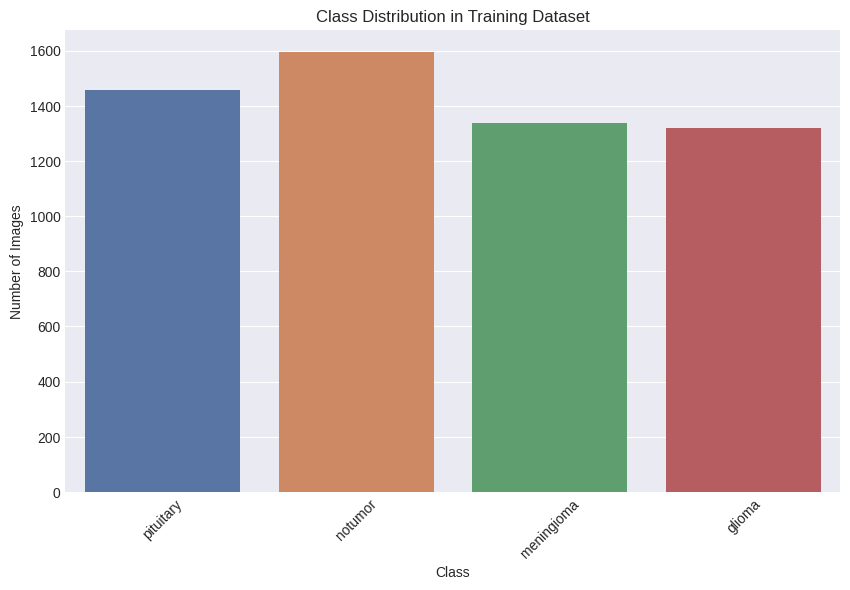

In [9]:
def plot_class_distribution(directory, title):
    """
    Plots the distribution of classes in the given directory.

    Args:
    directory (str): The path to the directory containing sub-folders for each class.
    """
    # Count the number of images in each class
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="deep")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()


plot_class_distribution("/content/Training", title="Class Distribution in Training Dataset")


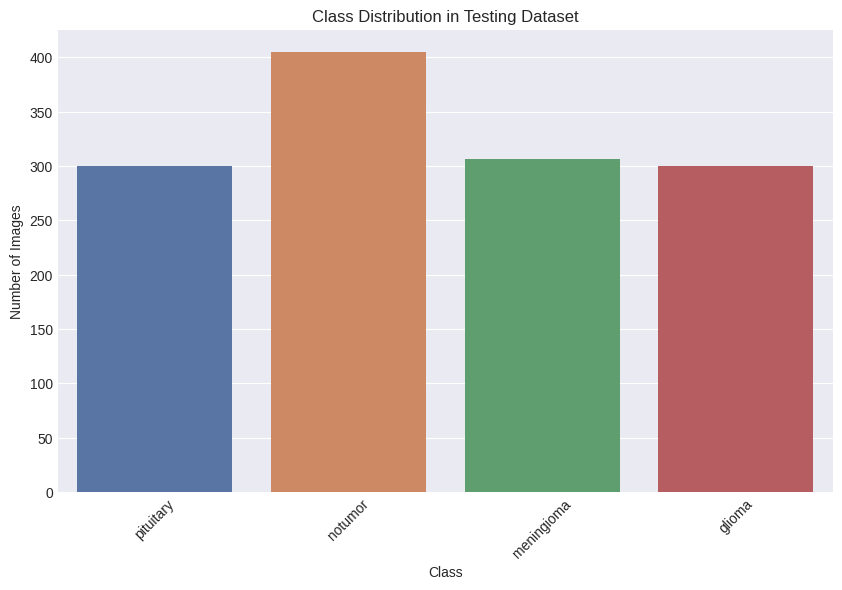

In [10]:
plot_class_distribution("/content/Testing", title="Class Distribution in Testing Dataset")

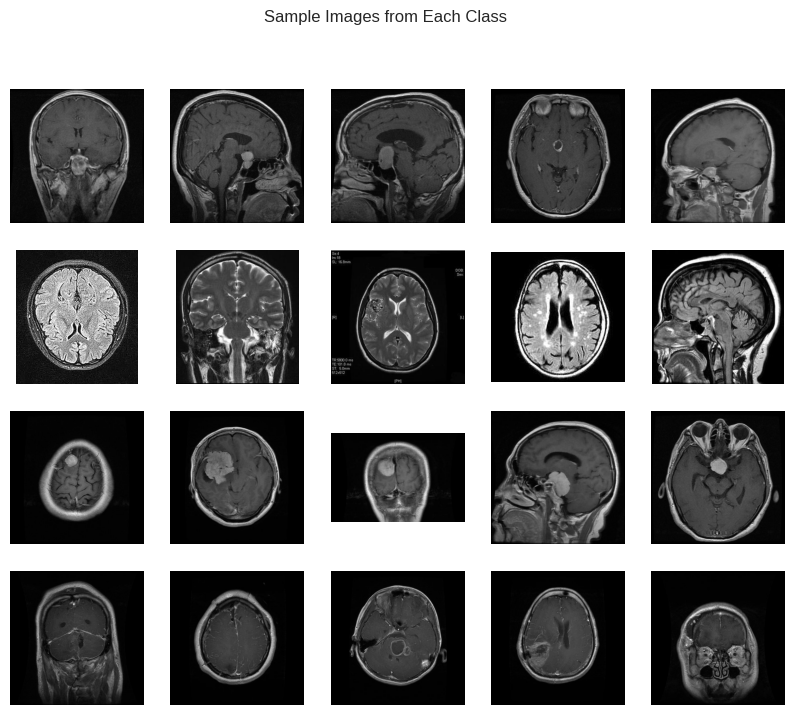

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(directory, samples_per_class=5):
    """
    Displays a grid of sample images from each class in the directory.

    Args:
    directory (str): The path to the directory containing sub-folders for each class.
    samples_per_class (int): Number of sample images per class to display.
    """
    classes = os.listdir(directory)
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(samples_per_class * 2, len(classes) * 2))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        for j, image_name in enumerate(os.listdir(class_dir)[:samples_per_class]):
            img = Image.open(os.path.join(class_dir, image_name))
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(class_name)

    plt.suptitle("Sample Images from Each Class")
    plt.show()

# Example usage:
plot_sample_images("/content/Training")


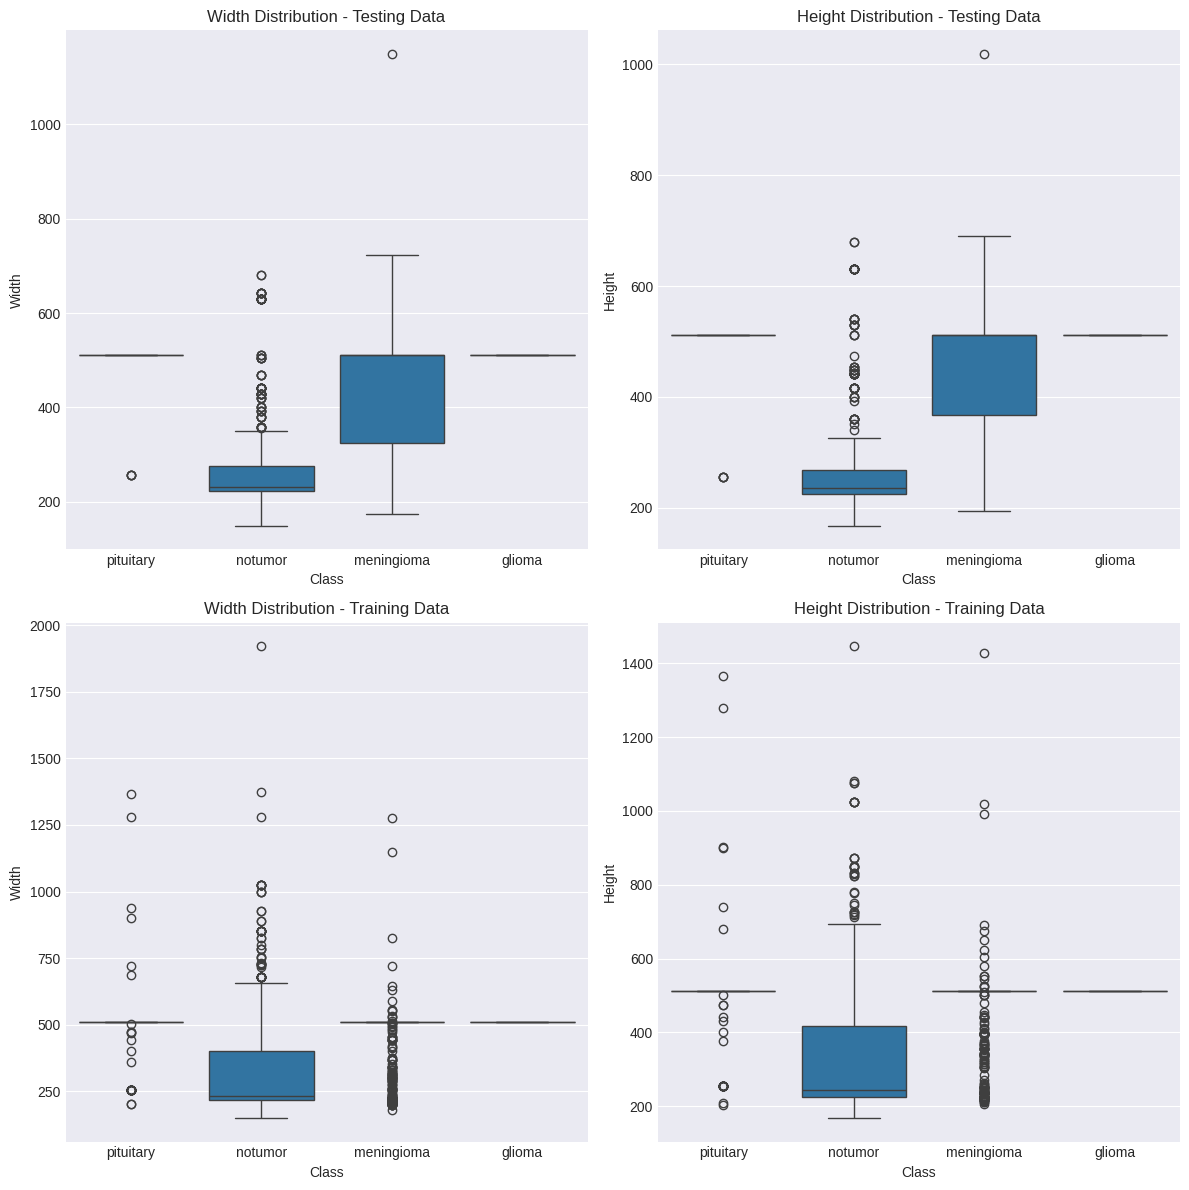

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import pandas as pd

def plot_image_resolutions(testing_dir, training_dir):
    # Function to extract resolutions
    def extract_resolutions(directory):
        resolutions = []
        labels = []
        for class_name in os.listdir(directory):
            class_dir = os.path.join(directory, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    with Image.open(os.path.join(class_dir, img_name)) as img:
                        resolutions.append(img.size)
                        labels.append(class_name)
        return pd.DataFrame(resolutions, columns=['Width', 'Height']), labels

    # Extract resolutions for testing and training data
    df_testing, labels_testing = extract_resolutions(testing_dir)
    df_testing['Class'] = labels_testing

    df_training, labels_training = extract_resolutions(training_dir)
    df_training['Class'] = labels_training

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Testing data plots
    sns.boxplot(x='Class', y='Width', data=df_testing, ax=axes[0, 0])
    axes[0, 0].set_title('Width Distribution - Testing Data')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Width')

    sns.boxplot(x='Class', y='Height', data=df_testing, ax=axes[0, 1])
    axes[0, 1].set_title('Height Distribution - Testing Data')
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('Height')

    # Training data plots
    sns.boxplot(x='Class', y='Width', data=df_training, ax=axes[1, 0])
    axes[1, 0].set_title('Width Distribution - Training Data')
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Width')

    sns.boxplot(x='Class', y='Height', data=df_training, ax=axes[1, 1])
    axes[1, 1].set_title('Height Distribution - Training Data')
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Height')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_image_resolutions("/content/Testing", "/content/Training")


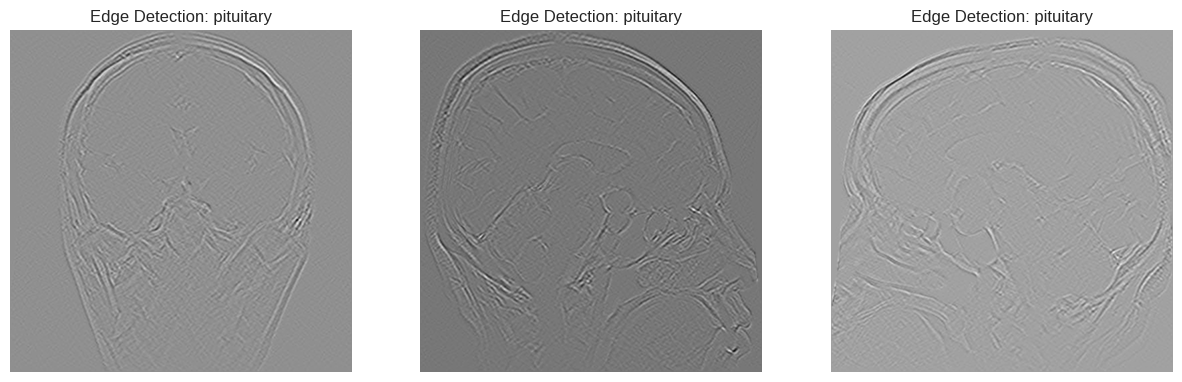

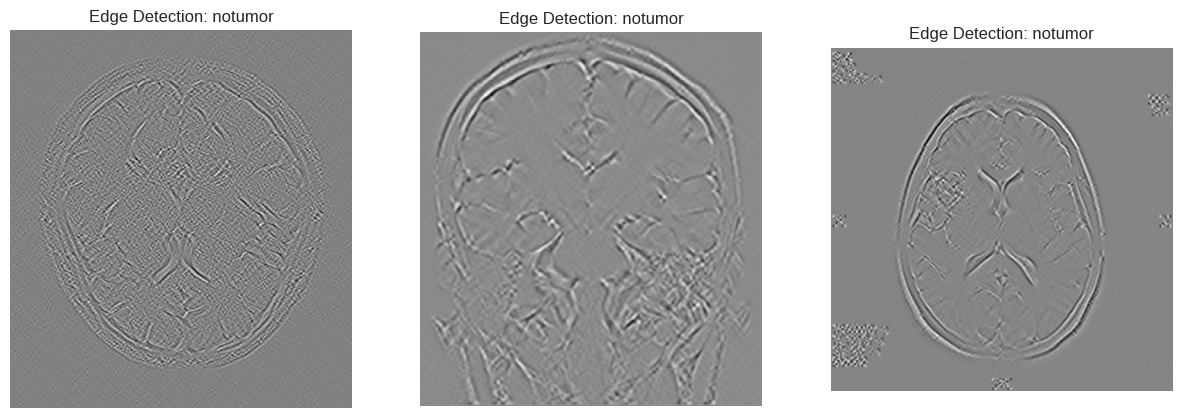

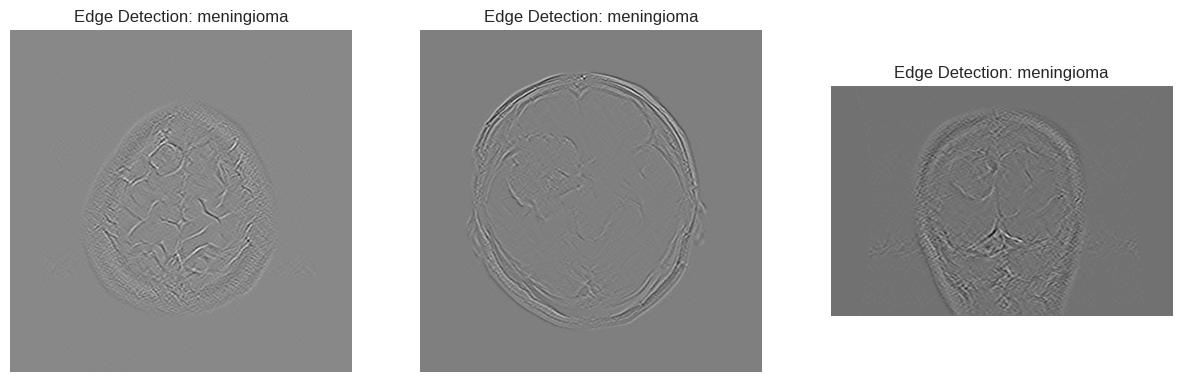

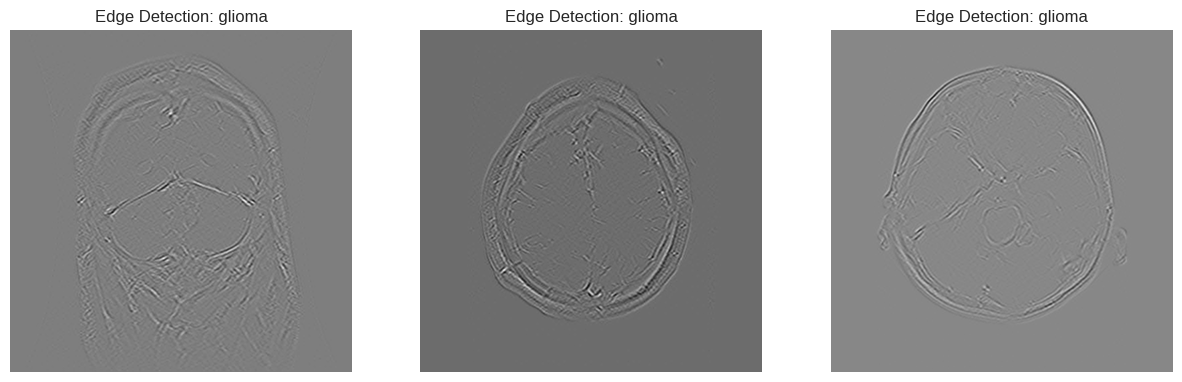

In [13]:
import cv2

def plot_edge_detection(directory, samples_per_class=3):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            fig, axes = plt.subplots(1, samples_per_class, figsize=(15, 5))
            for i, img_name in enumerate(os.listdir(class_dir)[:samples_per_class]):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path, 0)
                edges = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)

                axes[i].imshow(edges, cmap='gray')
                axes[i].set_title(f'Edge Detection: {class_name}')
                axes[i].axis('off')
            plt.show()

plot_edge_detection("/content/Training")


# Section 6: Building the Deep Learning Model


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

# Enable Mixed Precision Training
if tf.config.list_physical_devices('GPU'):
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled')

# Confirming that GPU is available
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if not gpu_devices:
    print('No GPU found. Using CPU')
else:
    print(f'GPUs found: {gpu_devices}')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)




Mixed precision enabled
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

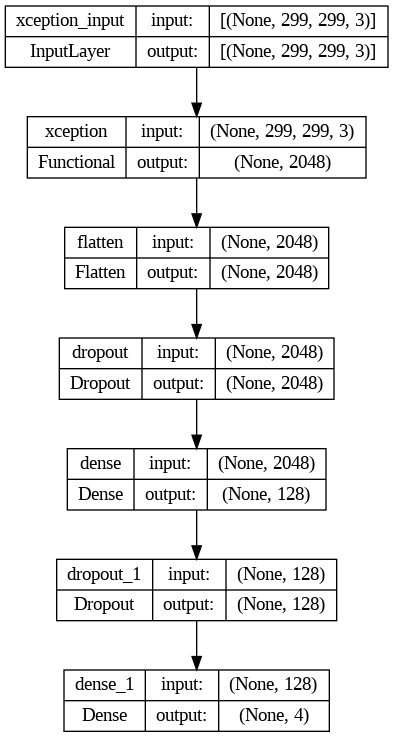

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Section 7: Model Training


In [17]:
# Train the model
hist = model.fit(tr_gen, epochs=10, validation_data=valid_gen, shuffle=False)


Epoch 1/10
357/357 [==============================] - 121s 226ms/step - loss: 0.3273 - accuracy: 0.8890 - precision: 0.9196 - recall: 0.8570 - val_loss: 0.2560 - val_accuracy: 0.9206 - val_precision: 0.9248 - val_recall: 0.9206
Epoch 2/10
357/357 [==============================] - 66s 185ms/step - loss: 0.0748 - accuracy: 0.9764 - precision: 0.9789 - recall: 0.9750 - val_loss: 0.0484 - val_accuracy: 0.9863 - val_precision: 0.9863 - val_recall: 0.9863
Epoch 3/10
357/357 [==============================] - 66s 184ms/step - loss: 0.0333 - accuracy: 0.9902 - precision: 0.9909 - recall: 0.9895 - val_loss: 0.1188 - val_accuracy: 0.9710 - val_precision: 0.9740 - val_recall: 0.9710
Epoch 4/10
357/357 [==============================] - 69s 192ms/step - loss: 0.0339 - accuracy: 0.9893 - precision: 0.9897 - recall: 0.9881 - val_loss: 0.0689 - val_accuracy: 0.9817 - val_precision: 0.9817 - val_recall: 0.9817
Epoch 5/10
357/357 [==============================] - 65s 183ms/step - loss: 0.0095 - accur

In [18]:
from google.colab import files

# Save the model to a file
model_file_name = 'trained_model.h5'
model.save(model_file_name)

# Automatically download the file to your local machine
# files.download(model_file_name)

# Section 8: Visualize Model Performance


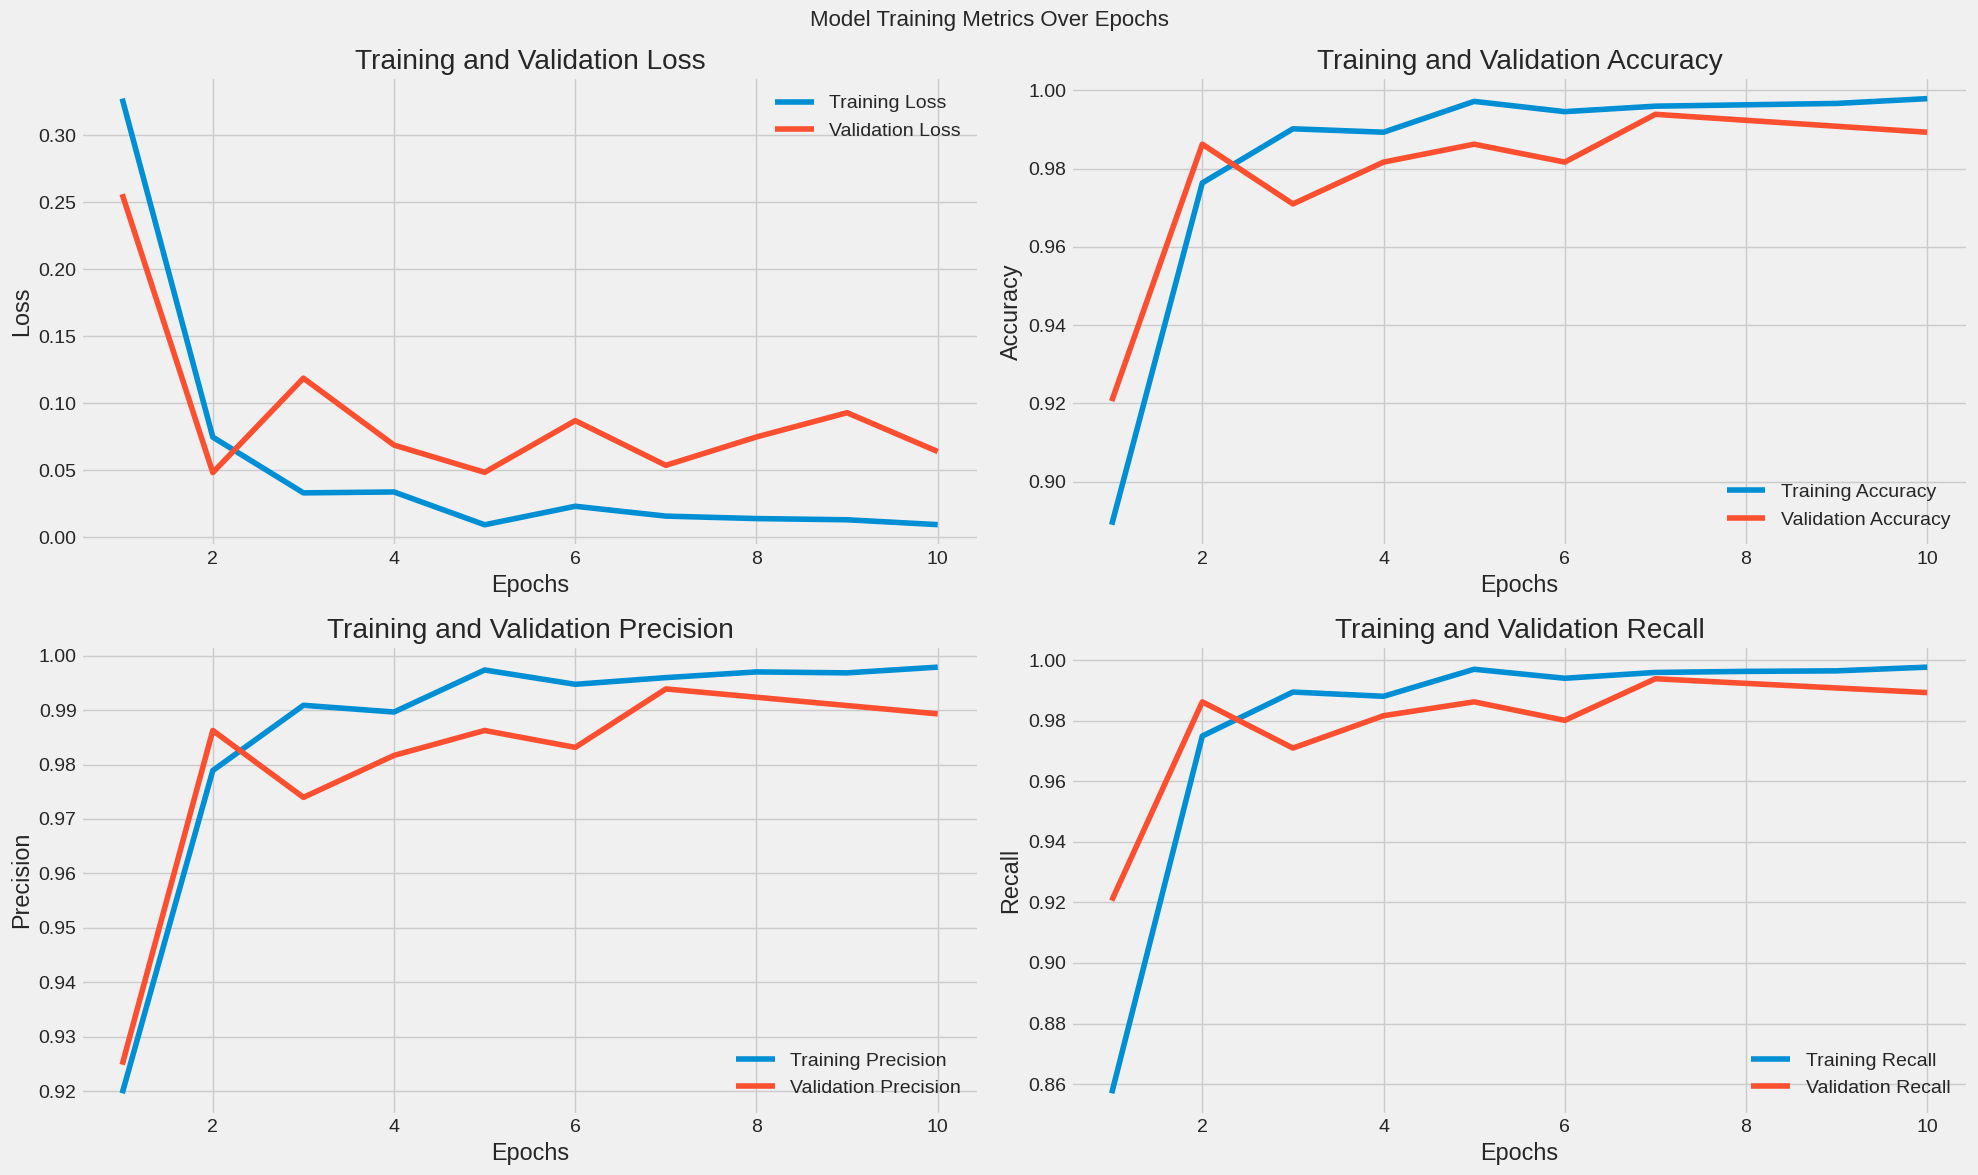

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_metrics(history):
    # Extracting available metrics from history
    tr_acc = history.get('accuracy', [])
    tr_loss = history.get('loss', [])
    val_acc = history.get('val_accuracy', [])
    val_loss = history.get('val_loss', [])

    # Setting the plot style
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(20, 12))

    # Plotting Loss
    plt.subplot(2, 2, 1)
    if tr_loss and val_loss:
        sns.lineplot(x=range(1, len(tr_loss) + 1), y=tr_loss, label='Training Loss')
        sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    # Plotting Accuracy
    plt.subplot(2, 2, 2)
    if tr_acc and val_acc:
        sns.lineplot(x=range(1, len(tr_acc) + 1), y=tr_acc, label='Training Accuracy')
        sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Check and plot Precision if available
    if 'precision' in history and 'val_precision' in history:
        tr_per = history['precision']
        val_per = history['val_precision']
        plt.subplot(2, 2, 3)
        sns.lineplot(x=range(1, len(tr_per) + 1), y=tr_per, label='Training Precision')
        sns.lineplot(x=range(1, len(val_per) + 1), y=val_per, label='Validation Precision')
        plt.title('Training and Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

    # Check and plot Recall if available
    if 'recall' in history and 'val_recall' in history:
        tr_recall = history['recall']
        val_recall = history['val_recall']
        plt.subplot(2, 2, 4)
        sns.lineplot(x=range(1, len(tr_recall) + 1), y=tr_recall, label='Training Recall')
        sns.lineplot(x=range(1, len(val_recall) + 1), y=val_recall, label='Validation Recall')
        plt.title('Training and Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

    # Adding supertitle
    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_metrics(hist.history)


# Section 9: Testing and Evaluation


41/41 [==============================] - 2s 56ms/step - loss: 0.0288 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924
Train Loss:  0.0025226145517081022
Train Accuracy:  0.9992997050285339
--------------------
Validation Loss:  0.06410786509513855
Validation Accuracy:  0.989313006401062
--------------------
Test Loss:  0.02881375513970852
Test Accuracy:  0.9923780560493469
41/41 [==============================] - 3s 55ms/step


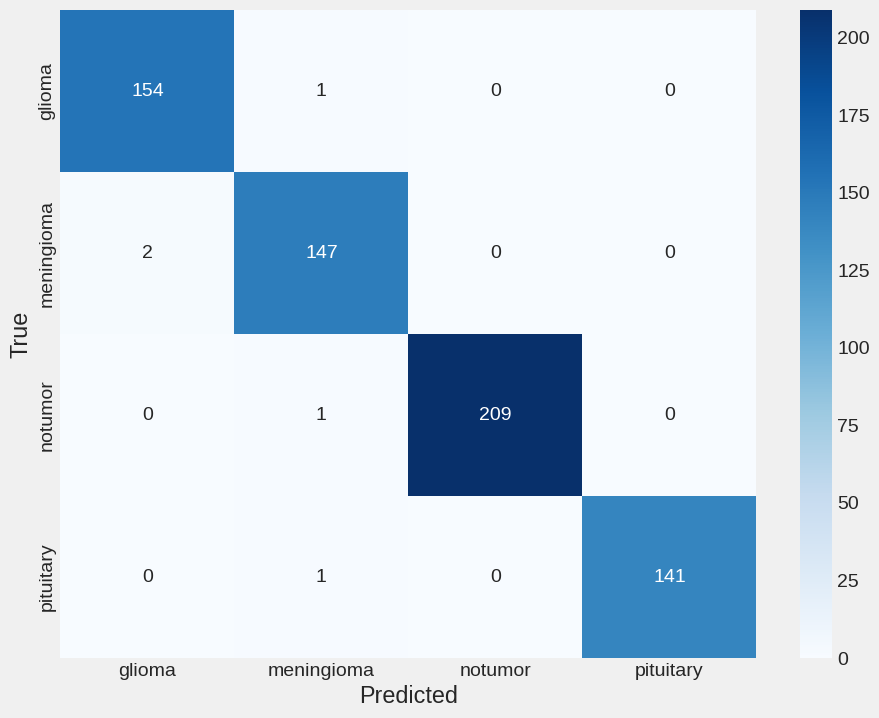

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       155
           1       0.98      0.99      0.98       149
           2       1.00      1.00      1.00       210
           3       1.00      0.99      1.00       142

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [20]:
# Evaluate the model on test data
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Confusion matrix and classification report
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(ts_gen.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tr_gen.class_indices, yticklabels=tr_gen.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(ts_gen.classes, y_pred))


# Section 10: Model Prediction Function


1/1 [==============================] - 1s 1s/step


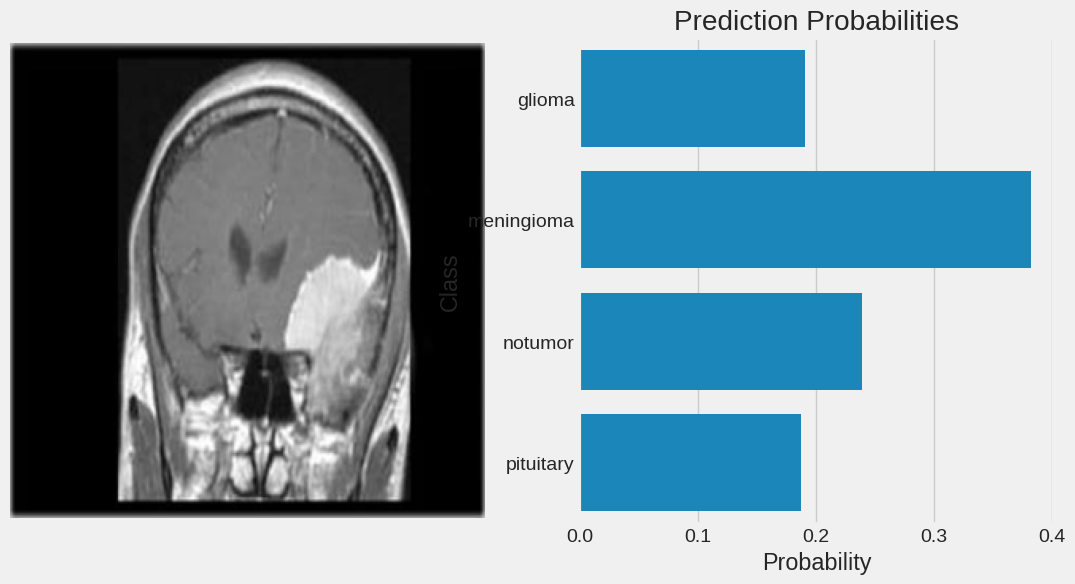

1/1 [==============================] - 0s 24ms/step


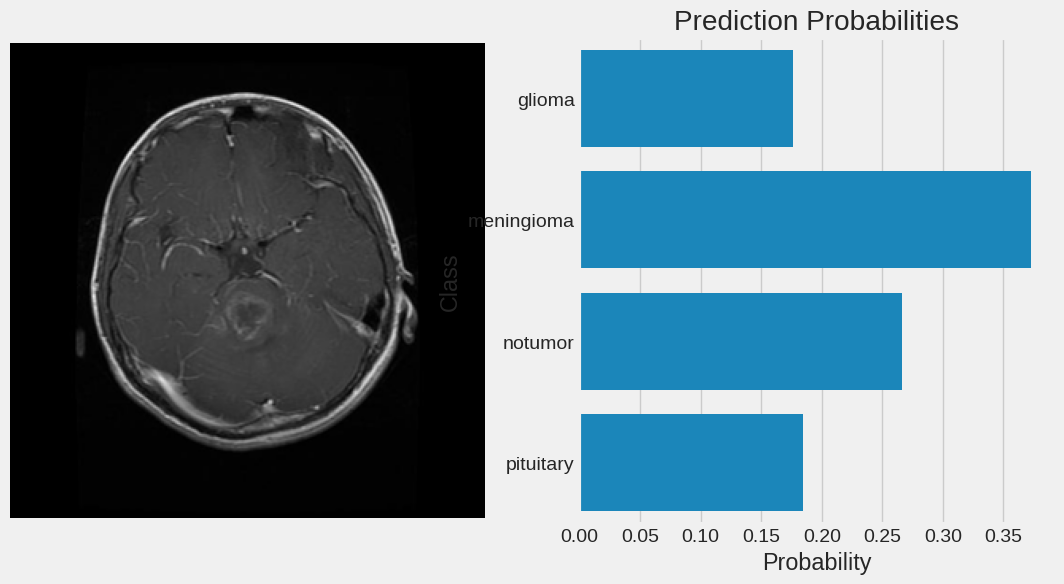

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

def predict_and_display(img_path, model, class_indices):
    img = Image.open(img_path)
    img_resized = img.resize((299, 299))
    img_array = np.asarray(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)

    # Convert predictions to DataFrame for easier plotting
    pred_df = pd.DataFrame(predictions, columns=class_indices.keys())

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Use DataFrame to plot
    sns.barplot(data=pred_df.T.reset_index(), x=0, y='index')
    plt.title('Prediction Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Class')
    plt.show()

# Example usage
predict_and_display('/content/Testing/meningioma/Te-meTr_0000.jpg', model, tr_gen.class_indices)
predict_and_display('/content/Testing/glioma/Te-glTr_0007.jpg', model, tr_gen.class_indices)

In [22]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21

In [23]:
base2=tf.keras.applications.nasnet.NASNetLarge(include_top=False,weights='imagenet',input_shape= img_shape)
base2.trainable = False
model1 = tf.keras.Sequential([
    base2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')
])

343610240/343610240 [==============================] - 3s 0us/step


In [24]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.Accuracy(),
                                                                                           tf.keras.metrics.Precision(),tf.keras.metrics.MeanAbsoluteError()])


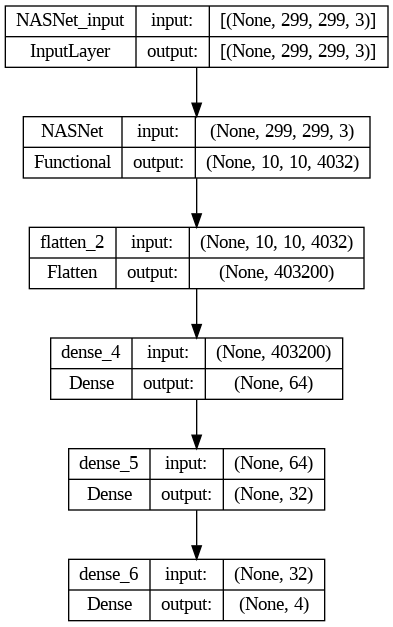

In [25]:
tf.keras.utils.plot_model(model1, show_shapes=True)

In [26]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 10, 10, 4032)      84916818  
                                                                 
 flatten_2 (Flatten)         (None, 403200)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                25804864  
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 4)                 132       
                                                                 
Total params: 110723894 (422.38 MB)
Trainable params: 25807076 (98.45 MB)
Non-trainable params: 84916818 (323.93 MB)
_________________________________________________________________


In [27]:
# Train the model
hist1 = model1.fit(tr_gen, epochs=10, validation_data=valid_gen, shuffle=False)


Epoch 1/10
357/357 [==============================] - 94s 203ms/step - loss: 6.6536 - root_mean_squared_error: 0.3837 - accuracy: 0.6235 - precision_2: 0.6854 - mean_absolute_error: 0.1590 - val_loss: 1.6050 - val_root_mean_squared_error: 0.2982 - val_accuracy: 0.6401 - val_precision_2: 0.8012 - val_mean_absolute_error: 0.1009
Epoch 2/10
357/357 [==============================] - 65s 181ms/step - loss: 1.3057 - root_mean_squared_error: 0.2814 - accuracy: 0.5375 - precision_2: 0.8208 - mean_absolute_error: 0.0935 - val_loss: 0.9841 - val_root_mean_squared_error: 0.2891 - val_accuracy: 0.3966 - val_precision_2: 0.8003 - val_mean_absolute_error: 0.1011
Epoch 3/10
357/357 [==============================] - 64s 180ms/step - loss: 0.4312 - root_mean_squared_error: 0.2124 - accuracy: 0.4091 - precision_2: 0.8884 - mean_absolute_error: 0.0624 - val_loss: 0.4291 - val_root_mean_squared_error: 0.2148 - val_accuracy: 0.3725 - val_precision_2: 0.8880 - val_mean_absolute_error: 0.0627
Epoch 4/10
35

In [28]:
from google.colab import files

# Save the model to a file
model_file_name = 'nasnet_model.h5'
model1.save(model_file_name)

# Automatically download the file to your local machine
files.download(model_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

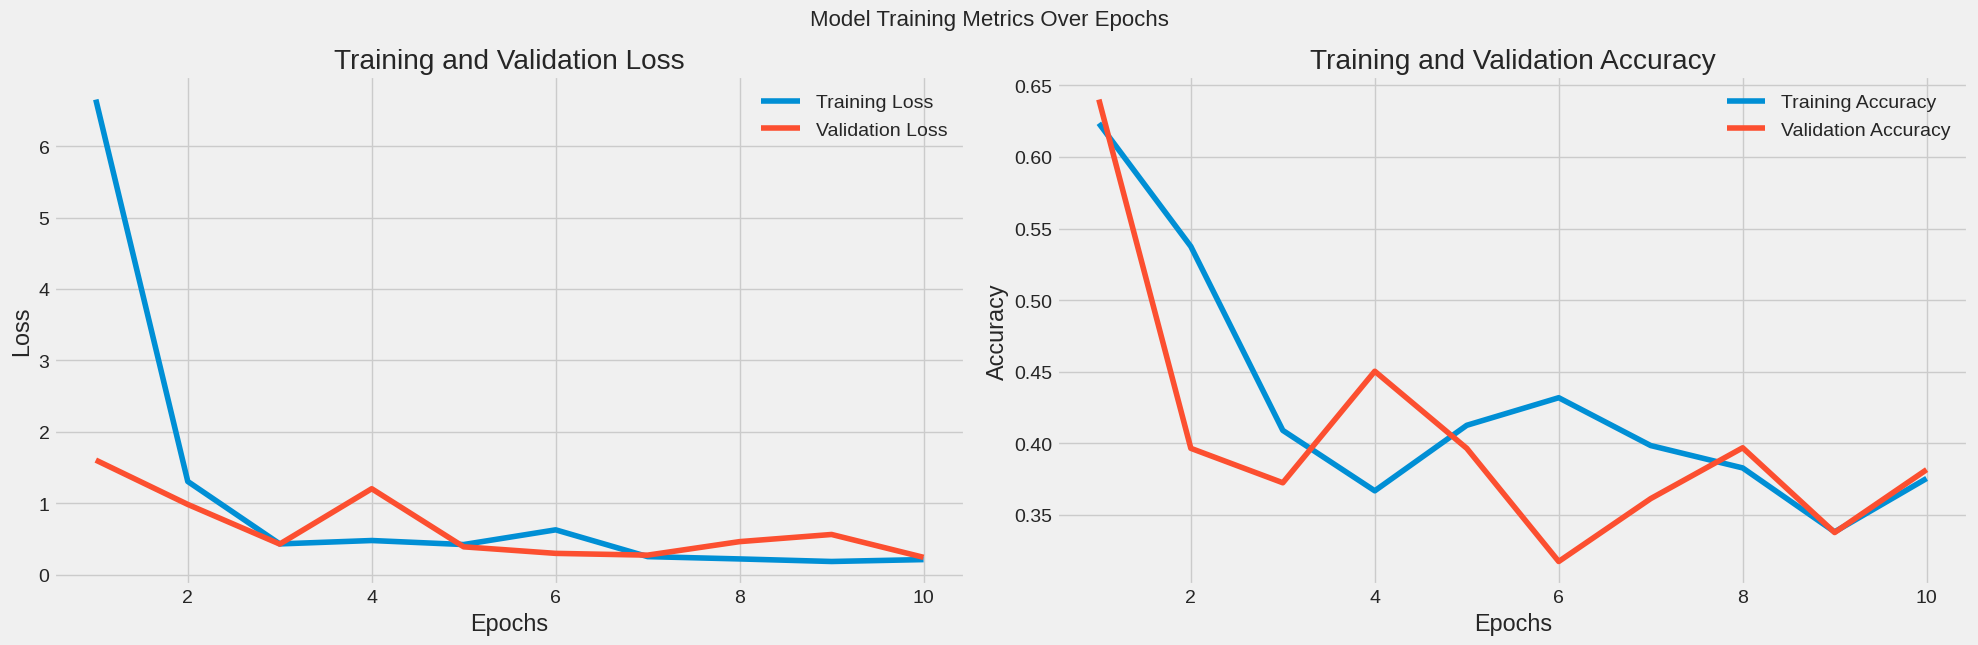

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_metrics(history):
    # Extracting available metrics from history
    tr_acc = history.get('accuracy', [])
    tr_loss = history.get('loss', [])
    val_acc = history.get('val_accuracy', [])
    val_loss = history.get('val_loss', [])

    # Setting the plot style
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(20, 12))

    # Plotting Loss
    plt.subplot(2, 2, 1)
    if tr_loss and val_loss:
        sns.lineplot(x=range(1, len(tr_loss) + 1), y=tr_loss, label='Training Loss')
        sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    # Plotting Accuracy
    plt.subplot(2, 2, 2)
    if tr_acc and val_acc:
        sns.lineplot(x=range(1, len(tr_acc) + 1), y=tr_acc, label='Training Accuracy')
        sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Check and plot Precision if available
    if 'precision' in history and 'val_precision' in history:
        tr_per = history['precision']
        val_per = history['val_precision']
        plt.subplot(2, 2, 3)
        sns.lineplot(x=range(1, len(tr_per) + 1), y=tr_per, label='Training Precision')
        sns.lineplot(x=range(1, len(val_per) + 1), y=val_per, label='Validation Precision')
        plt.title('Training and Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

    # Check and plot Recall if available
    if 'recall' in history and 'val_recall' in history:
        tr_recall = history['recall']
        val_recall = history['val_recall']
        plt.subplot(2, 2, 4)
        sns.lineplot(x=range(1, len(tr_recall) + 1), y=tr_recall, label='Training Recall')
        sns.lineplot(x=range(1, len(val_recall) + 1), y=val_recall, label='Validation Recall')
        plt.title('Training and Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

    # Adding supertitle
    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_metrics(hist1.history)


41/41 [==============================] - 2s 50ms/step - loss: nan - accuracy: 0.2927 - precision_1: 0.2928 - recall_1: 0.2896
Train Loss:  nan
Train Accuracy:  0.2855392098426819
--------------------
Validation Loss:  nan
Validation Accuracy:  0.29160305857658386
--------------------
Test Loss:  nan
Test Accuracy:  0.2926829159259796
41/41 [==============================] - 3s 63ms/step


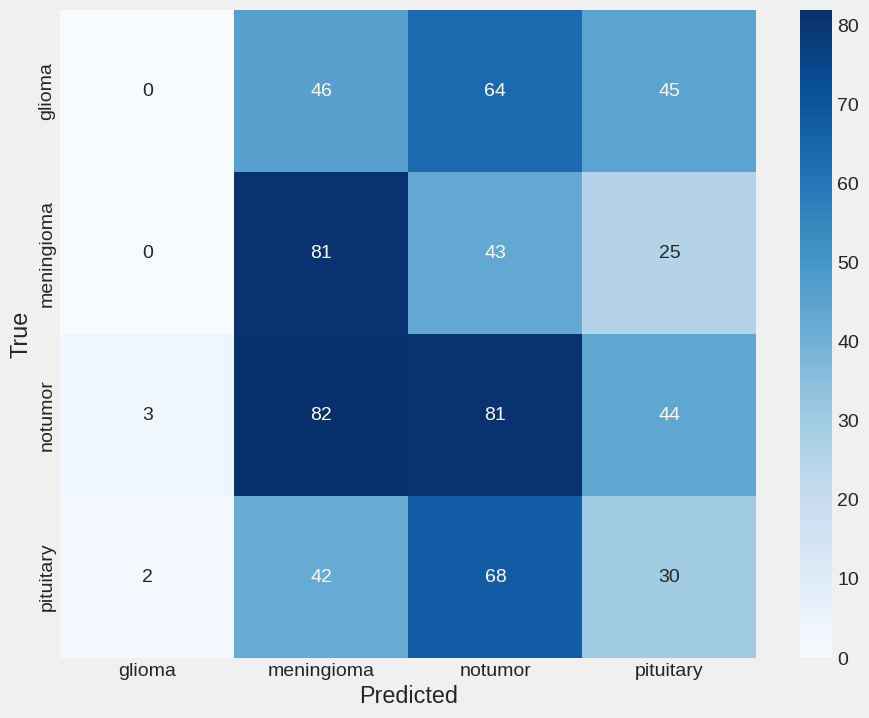

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       155
           1       0.32      0.54      0.41       149
           2       0.32      0.39      0.35       210
           3       0.21      0.21      0.21       142

    accuracy                           0.29       656
   macro avg       0.21      0.29      0.24       656
weighted avg       0.22      0.29      0.25       656



In [30]:
# Evaluate the model on test data
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Confusion matrix and classification report
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(ts_gen.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tr_gen.class_indices, yticklabels=tr_gen.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(ts_gen.classes, y_pred))


1/1 [==============================] - 1s 783ms/step


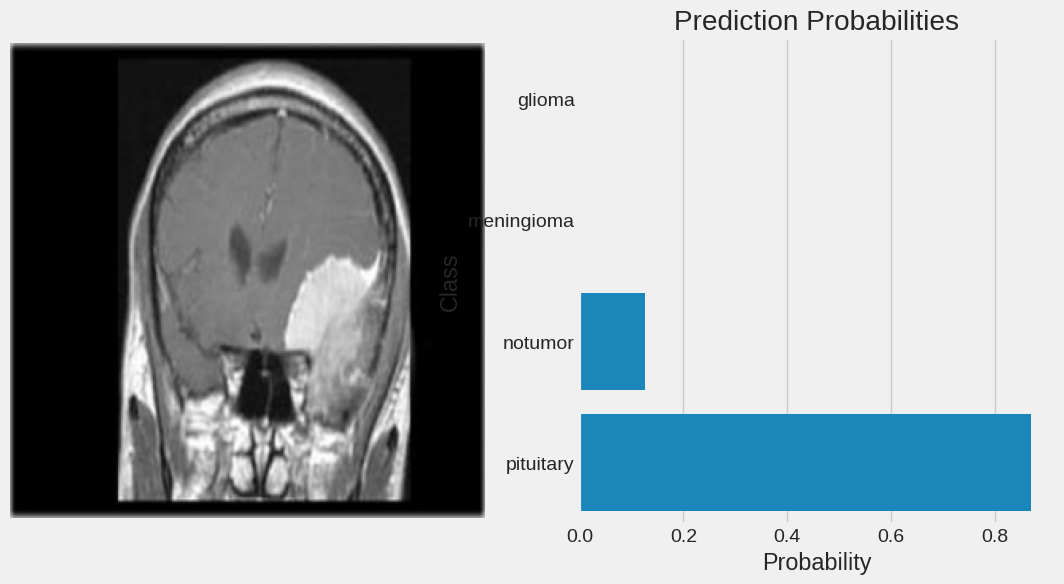

1/1 [==============================] - 0s 24ms/step


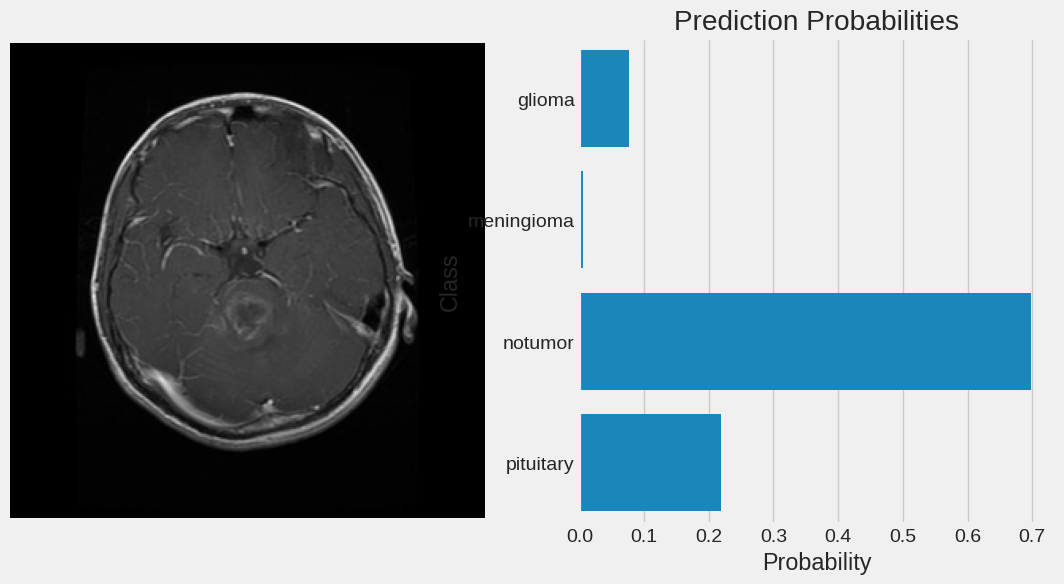

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

def predict_and_display(img_path, model, class_indices):
    img = Image.open(img_path)
    img_resized = img.resize((299, 299))
    img_array = np.asarray(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)

    # Convert predictions to DataFrame for easier plotting
    pred_df = pd.DataFrame(predictions, columns=class_indices.keys())

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Use DataFrame to plot
    sns.barplot(data=pred_df.T.reset_index(), x=0, y='index')
    plt.title('Prediction Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Class')
    plt.show()

# Example usage
predict_and_display('/content/Testing/meningioma/Te-meTr_0000.jpg', model, tr_gen.class_indices)
predict_and_display('/content/Testing/glioma/Te-glTr_0007.jpg', model, tr_gen.class_indices)